# Chapter: Input-Output Modeling - Part 1: 


## Topic: Industrial Fired Heater Modeling via FIR model

In [1]:
# import packages 
import matplotlib.pyplot as plt, numpy as np, control
from sklearn.preprocessing import StandardScaler
from sippy import system_identification as SysID
from statsmodels.tsa.stattools import ccf

# package settings
plt.rcParams.update({'font.size': 14})
assert(control.__version__ < '0.9'), "To avoid errors, downgrade the control package to a version < 0.9.0. See https://github.com/CPCLAB-UNIPI/SIPPY/issues/48 for details."

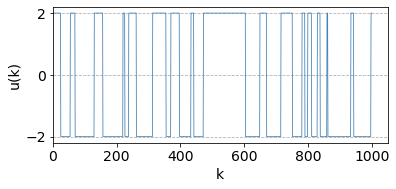

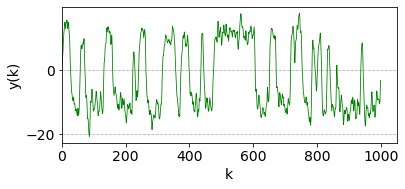

In [2]:
# read fired heater identification test data and plot
data = np.loadtxt('IndustrialFiredHeater_SISO.csv', delimiter=',')
FG, TO = data[:,0, None], data[:,1, None]

# plots
plt.figure(figsize=(6,2.5)), plt.plot(FG, 'steelblue', linewidth=0.8)
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(TO, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [3]:
# center data before model fitting
u_scaler = StandardScaler(with_std=False) 
FG_centered = u_scaler.fit_transform(FG) 

y_scaler = StandardScaler(with_std=False) 
TO_centered = y_scaler.fit_transform(TO) 

In [4]:
# fit FIR model using AIC 
FIRmodel = SysID(TO_centered, FG_centered, 'FIR', IC='AIC', nb_ord=[1,20]) # a range of 1 to 20 is specified for optimal order search 
print(FIRmodel.G)

suggested orders are: Na= 0 ; Nb= 11 Delay:  0

1.202 z^10 + 1.094 z^9 + 0.8667 z^8 + 0.6957 z^7 + 0.5106 z^6 + 0.3635 z^5 + 0.2825 z^4 + 0.2338 z^3 + 0.09618 z^2 + 0.1258 z + 0.2265
--------------------------------------------------------------------------------------------------------------------------------------
                                                                 z^11

dt = 1.0



Note that SIPPY and the Control packages use the symbol z to represent the (forward) shift operator. In our book, we use the symbol q and represent the transfer operators in terms of backward shift operator.

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

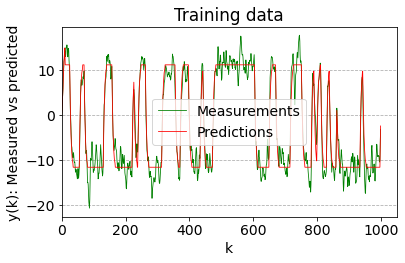

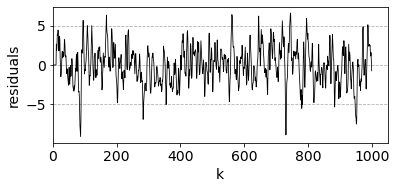

In [6]:
# get model predictions and residuals on training dataset
TO_predicted_centered = FIRmodel.Yid # Yid attribute provides the output of the identified model during model ID
TO_predicted = np.transpose(y_scaler.inverse_transform(TO_predicted_centered))
residuals = TO - TO_predicted

plt.figure(figsize=(6,3.5)), plt.plot(TO, 'g', linewidth=0.8, label='Measurements'), plt.plot(TO_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Training data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5))
plt.plot(residuals, 'black', linewidth=0.8)
plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [7]:
# CCF b/w residual and input sequences
ccf_vals = ccf(residuals, FG, adjusted=False) # ccf for lag >= 0
ccf_vals = ccf_vals[:21] # ccf for lag 0 to 20

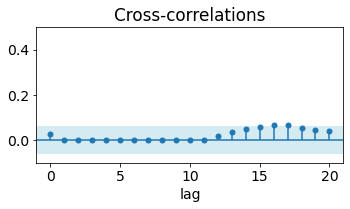

In [8]:
# generate CCF plot
lags, conf_int = np.arange(0,21), 1.96/np.sqrt(len(residuals))

plt.figure(figsize=(5.5,2.5)), plt.vlines(lags, [0], ccf_vals), plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.1, 0.5)
plt.show()

In [9]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                Compare step responses: Model vs Process
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

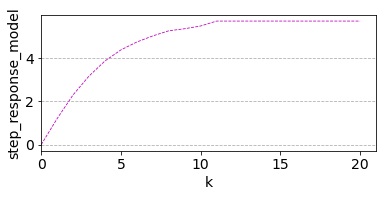

In [10]:
# generate step response of FIR model
step_response_model, _ = control.matlab.step(FIRmodel.G, T=21)

plt.figure(figsize=(6,2.5))
plt.plot(step_response_model, 'm--', linewidth=0.8)
plt.ylabel('step_response_model'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

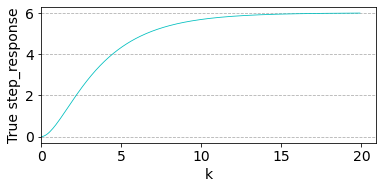

In [11]:
# generate step response of original process
# define the original process
s = control.matlab.tf('s')
sys_G  = 6/(3*s**2 + 4*s + 1)

# get step response
step_response_process, T = control.matlab.step(sys_G, T=20)

plt.figure(figsize=(6,2.5))
plt.plot(T, step_response_process, 'c', linewidth=0.8)
plt.ylabel('True step_response'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

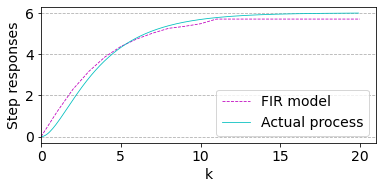

In [12]:
# overlay the step responses
plt.figure(figsize=(6,2.5))
plt.plot(step_response_model, 'm--', linewidth=0.8, label="FIR model")
plt.plot(T, step_response_process, 'c', linewidth=0.8, label="Actual process")
plt.ylabel('Step responses'), plt.xlabel('k'), plt.xlim(0)
plt.legend()
plt.grid(which='both', axis='y', linestyle='--')
plt.show()